# Task 8: use LinearSVC on linear-separable dataset, then train on the same dataset SVC and SGDClassifier and compare the results

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import reciprocal, uniform
from sklearn.datasets import load_iris, fetch_openml, fetch_california_housing
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR
from sklearn.svm import SVC, LinearSVC
from sklearn.svm import SVR

In [2]:
iris = load_iris()

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

In [3]:
C = 5
alpha = 1 / (C * len(X))

lin_clf = LinearSVC(loss="hinge", C=C, random_state=42)

svm_clf = SVC(kernel="linear", C=C)

sgd_clf = SGDClassifier(loss="hinge",
                        learning_rate="constant",
                        eta0=0.001,
                        alpha=alpha,
                        max_iter=1000,
                        tol=1e-3,
                        random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lin_clf.fit(X_scaled, y)
svm_clf.fit(X_scaled, y)
sgd_clf.fit(X_scaled, y)

print("LinearSVC:                   ", lin_clf.intercept_, lin_clf.coef_)
print("SVC:                         ", svm_clf.intercept_, svm_clf.coef_)
print("SGDClassifier(alpha={:.5f}):".format(sgd_clf.alpha), sgd_clf.intercept_, sgd_clf.coef_)

LinearSVC:                    [0.28475098] [[1.05364854 1.09903804]]
SVC:                          [0.31896852] [[1.1203284  1.02625193]]
SGDClassifier(alpha=0.00200): [0.117] [[0.77714169 0.72981762]]


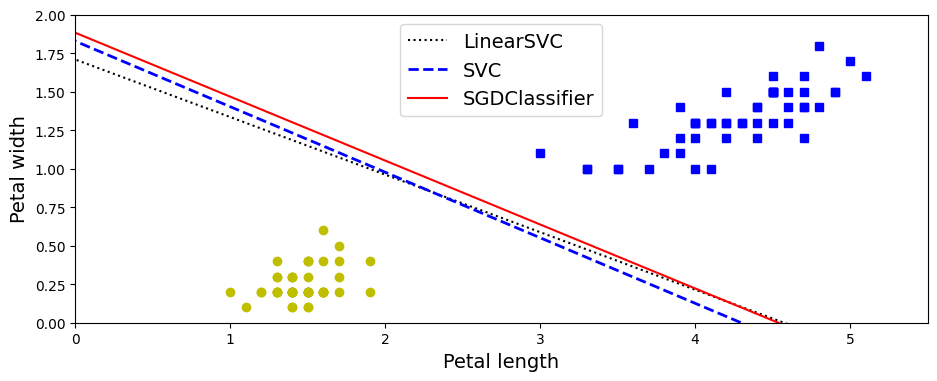

In [4]:
# Let's plot the decision boundaries of these three models:
# Compute the slope and bias of each decision boundary

w1 = -lin_clf.coef_[0, 0]/lin_clf.coef_[0, 1]
b1 = -lin_clf.intercept_[0]/lin_clf.coef_[0, 1]
w2 = -svm_clf.coef_[0, 0]/svm_clf.coef_[0, 1]
b2 = -svm_clf.intercept_[0]/svm_clf.coef_[0, 1]
w3 = -sgd_clf.coef_[0, 0]/sgd_clf.coef_[0, 1]
b3 = -sgd_clf.intercept_[0]/sgd_clf.coef_[0, 1]

# Transform the decision boundary lines back to the original scale
line1 = scaler.inverse_transform([[-10, -10 * w1 + b1], [10, 10 * w1 + b1]])
line2 = scaler.inverse_transform([[-10, -10 * w2 + b2], [10, 10 * w2 + b2]])
line3 = scaler.inverse_transform([[-10, -10 * w3 + b3], [10, 10 * w3 + b3]])

# Plot all three decision boundaries
plt.figure(figsize=(11, 4))
plt.plot(line1[:, 0], line1[:, 1], "k:", label="LinearSVC")
plt.plot(line2[:, 0], line2[:, 1], "b--", linewidth=2, label="SVC")
plt.plot(line3[:, 0], line3[:, 1], "r-", label="SGDClassifier")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs") # label="Iris versicolor"
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo") # label="Iris setosa"
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper center", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.show()

In [5]:
# Close enough!

In [6]:
# Task 9: Use  SVM on MNIST dataset ( what max accuracy you can get ?)

In [7]:
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)

X = mnist["data"]
y = mnist["target"].astype(np.uint8)

X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

In [8]:
# Many training algorithms are sensitive to the order of the training instances,
# so it's generally good practice to shuffle them first.
# However, the dataset is already shuffled, so we do not need to do it.

# Let's start simple, with a linear SVM classifier.
# It will automatically use the One-vs-All (also called One-vs-the-Rest, OvR) strategy,
# so there's nothing special we need to do. Easy!

lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train, y_train)
y_pred = lin_clf.predict(X_train)
score = accuracy_score(y_train, y_pred)
score
# # Okay, 83.5% accuracy on MNIST is pretty bad.

0.9275

In [9]:
 # This linear model is certainly too simple for MNIST,
 # but perhaps we just needed to scale the data first:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
X_test_scaled = scaler.transform(X_test.astype(np.float32))
y_pred = lin_clf.predict(X_train_scaled)
score = accuracy_score(y_train, y_pred)
score
# That's much better (we cut the error rate by about 53%), but still not great at all for MNIST.

0.24343333333333333

In [10]:
# If we want to use an SVM, we will have to use a kernel.
# Let's try an SVC with an RBF kernel (the default).

# Note: to be future-proof we set gamma="scale" since it will be the default value in Scikit-Learn 0.22.

svm_clf = SVC(gamma="scale")
svm_clf.fit(X_train_scaled[:10000], y_train[:10000])
y_pred = svm_clf.predict(X_train_scaled)
score = accuracy_score(y_train, y_pred)
score

0.9455333333333333

In [11]:
# That's promising, we get better performance even though we trained the model on 6 times less data. Let's tune the hyperparameters by doing a randomized search with cross validation. We will do this on a small dataset just to speed up the process:

param_distributions = {"gamma": reciprocal(0.001, 0.1),
                       "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_cv.fit(X_train_scaled[:1000], y_train[:1000])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ....C=9.60593986710334, gamma=0.0016143507472357872; total time=   0.3s
[CV] END ....C=9.60593986710334, gamma=0.0016143507472357872; total time=   0.3s
[CV] END ....C=9.60593986710334, gamma=0.0016143507472357872; total time=   0.3s
[CV] END ........C=2.4995389813367, gamma=0.0272780270882811; total time=   0.4s
[CV] END ........C=2.4995389813367, gamma=0.0272780270882811; total time=   0.4s
[CV] END ........C=2.4995389813367, gamma=0.0272780270882811; total time=   0.4s
[CV] END ...C=10.160817373119722, gamma=0.002534805512297741; total time=   0.4s
[CV] END ...C=10.160817373119722, gamma=0.002534805512297741; total time=   0.3s
[CV] END ...C=10.160817373119722, gamma=0.002534805512297741; total time=   0.4s
[CV] END .....C=4.385443292480694, gamma=0.07520498679799005; total time=   0.4s
[CV] END .....C=4.385443292480694, gamma=0.07520498679799005; total time=   0.4s
[CV] END .....C=4.385443292480694, gamma=0.07520

,estimator,SVC()
,param_distributions,"{'C': <scipy.stats....00253C2567D90>, 'gamma': <scipy.stats....00253C266C2F0>}"
,n_iter,10
,scoring,None
,n_jobs,None
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [12]:
best_model = rnd_search_cv.best_estimator_
best_score = rnd_search_cv.best_score_

# Task 10: Train SVM on California housing dataset (regression task)

In [13]:
housing = fetch_california_housing()
X = housing["data"]
y = housing["target"]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
lin_svr = LinearSVR(random_state=42)
lin_svr.fit(X_train_scaled, y_train)

C:\Users\username\Projects\MachineLearning\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,epsilon,0.0
,tol,0.0001
,C,1.0
,loss,'epsilon_insensitive'
,fit_intercept,True
,intercept_scaling,1.0
,dual,'auto'
,verbose,0
,random_state,42
,max_iter,1000


In [17]:
# Let's see how it performs on the training set:
y_pred = lin_svr.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_pred)
mse

0.9641780189948643

In [18]:
np.sqrt(mse) # Let's look at the RMSE:

np.float64(0.9819256687727764)

In [19]:
# In this training set, the targets are tens of thousands of dollars.
# The RMSE gives a rough idea of the kind of error you should expect
# (with a higher weight for large errors): so with this model we can expect errors somewhere around $10,000. Not great. Let's see if we can do better with an RBF Kernel.
# We will use randomized search with cross validation to find
# the appropriate hyperparameter values for C and gamma:

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(SVR(),
                                   param_distributions,
                                   n_iter=10,
                                   verbose=0,
                                   cv=3,
                                   random_state=42,
                                   n_jobs=-1,
                                   return_train_score=False)
rnd_search_cv.fit(X_train_scaled, y_train)

,estimator,SVR()
,param_distributions,"{'C': <scipy.stats....00253C25C9F30>, 'gamma': <scipy.stats....00253C25679D0>}"
,n_iter,10
,scoring,None
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [20]:
best_model = rnd_search_cv.best_estimator_
best_score = rnd_search_cv.best_score_
best_params = rnd_search_cv.best_params_

In [24]:
best_score

np.float64(0.7382573066913443)

In [23]:
best_params

{'C': np.float64(4.745401188473625), 'gamma': np.float64(0.07969454818643935)}

In [21]:
y_pred = best_model.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_pred)
score = np.sqrt(mse)
score

np.float64(0.5727456438057156)

In [22]:
# Looks much better than the linear model. Let's select this model and evaluate it on the test set:

y_pred = best_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
score = np.sqrt(mse)
score

np.float64(0.5929120979852832)